----

# Определение перспективного тарифа для телеком компании

#### Цели проекта. 
Сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей компании: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Мы имеем пять таблиц. Users c данными о пользователях,  Calls c данными о звонках, Messages c даннами о сообщениях, Internet c данными о трафике и tariffs c данными о действующих тарифах. 

Ниже приведены по несколько строк из каждой таблицы, что бы можно было составить представление о данных.

### Шаг 1. Открытие файлов с данными.

In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [3]:
# Загружаем данные
data_calls = pd.read_csv('/datasets/calls.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

In [4]:
# Пердпросмотре данных
print('-'*28, 'Первые строки таблицы:', 'data_users', '-'*28)
display(data_users.head(3))
print('-'*28, 'Первые строки таблицы:', 'data_calls', '-'*28)
display(data_calls.head(3))
print('-'*28, 'Первые строки таблицы:', 'data_messages', '-'*28)
display(data_messages.head(3))
print('-'*28, 'Первые строки таблицы:', 'data_internet', '-'*28)
display(data_internet.head(3))
print('-'*28, 'Первые строки таблицы:', 'data_tariffs', '-'*28)
display(data_tariffs.head(3))

---------------------------- Первые строки таблицы: data_users ----------------------------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


---------------------------- Первые строки таблицы: data_calls ----------------------------


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


---------------------------- Первые строки таблицы: data_messages ----------------------------


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


---------------------------- Первые строки таблицы: data_internet ----------------------------


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000


---------------------------- Первые строки таблицы: data_tariffs ----------------------------


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Посмотрим на табицу звонков

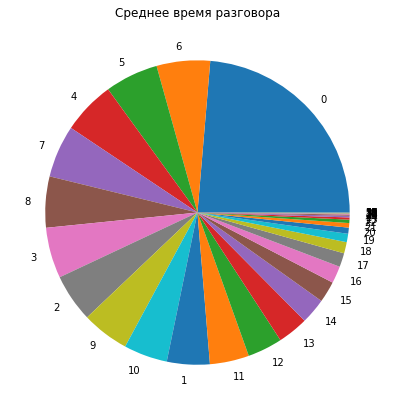

Среднее время звонка без учета недозвонов - 8 минут.


In [28]:
# На данном этапе нам интересна лишь таблица со звонкаими. Посмотрим график продолжительности звонков
data_calls['duration'].astype('int').value_counts().plot(kind='pie', figsize=(7,7),
                                                        title="Среднее время разговора")
plt.ylabel('')
plt.show()
print('Среднее время звонка без учета недозвонов - {:.0f} минут.'.format(
      data_calls[data_calls['duration'] != 0]['duration'].mean()))

#### Вывод
Почти четверть звонков со значением 0. Вполне логично предположить, что это могут быть разного рода недозвоны - не взяли трубку, абонент недоступен и т.д.  В остальном данные выглядят вполне нормально. 

С интернетом ситуация похожая, однако там процент нулей около 10, поэтому не будем с этим отдельно разбираться, предположительно это особенности рагистрации учета трафика. Или так учитывается трафик, который считается бесплатным, например, к приложению своего оператора, или каким либо обозначенным в тарифе сервисам.

### Шаг 2. Подготовка данных

In [6]:
# Добавим поле с округленными минутами разговора
data_calls['duration_min'] = data_calls['duration'].apply(np.ceil).apply(int)

# Округлим мегабайты в большую сторону. В отличие от минут оригинальные значения сохранять не станем,
# так как медиана трафика 348 мб, а разговора - 6 минут. В минутах округление даст большую погрушность.
data_internet['mb_used'] = data_internet['mb_used'].apply(np.ceil).apply(int)

# Добавим тариф к остальным таблицам
data_calls = data_calls.merge(data_users.loc[:,['user_id', 'tariff']], on=('user_id'))
data_internet = data_internet.merge(data_users.loc[:,['user_id', 'tariff']], on=('user_id'))

# Добавим поле с оттоком
data_users['is_churn'] = data_users['churn_date'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [8]:
# Преобразовываем даты
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'])
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'])
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'])
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'])
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'])

In [9]:
# Добавим поле месяц
data_calls['month'] = (data_calls['call_date'].dt.month)
data_internet['month'] = (data_internet['session_date'].dt.month)
data_messages['month'] = (data_messages['message_date'].dt.month)
data_users['month_reg'] = (data_users['reg_date'].dt.month)

In [10]:
# Сгруппируем города по трем группам - Москва, Санкт-Петербург и остальные.
data_users['city_grouped'] = data_users['city'].apply(
    lambda city: city if city in ['Москва', 'Санкт-Петербург'] else 'Остальные'
                                                      )

In [11]:
# Создадим объединенную таблицу со всеми нужными данными

# Сгруппируем звонки
calls_grouped = (data_calls.groupby(['user_id','month'])
                 ['duration_min'].sum().reset_index())

# Сгруппируем трафик
internet_grouped = (data_internet.groupby(['user_id','month'])
                    ['mb_used'].sum().reset_index())

# Сгруппируем сообщения
mesages_grouped = (data_messages.groupby(['user_id','month'])
                   ['id'].count().reset_index())
# Объединим данные
full_data = calls_grouped.merge(internet_grouped, how='outer', on=('user_id','month'))
full_data = full_data.merge(mesages_grouped, how='outer', on=('user_id','month'))
full_data.columns = ['user_id', 'month', 'min_per_month',
                     'mb_per_month','sms_per_month']

# Добавим данные из таблицы с пользователями
full_data = full_data.merge(data_users[['user_id','age', 'tariff', 'is_churn',
                                        'city_grouped']], how='outer',  on=('user_id'))

# Добавим информация из таблицы с тарифами
full_data = full_data.merge(data_tariffs, left_on='tariff', right_on='tariff_name')

# Удалим столбец с повторяющимися данными
full_data = full_data.drop(columns=['tariff_name'])

# Есть два пользователя, которые подключились и отключились от тарифа неуспев воспользоваться услугами.
first_month_churned = list(full_data[full_data['month'].isnull()]['user_id'])

# Так как эти пользователи, предположительно заплатили абонентскую плату, не будем их удалать
data_users.query('user_id in @first_month_churned')[['reg_date', 'churn_date']]

# Так как речь идет всего о двух пользователях, не будем излишне усложнять, укажем в месяце декабрь. 
full_data['month'].fillna(value=12,inplace=True)

# Пропуски в остальных столбцах заполним нулями, так как пользователи не пользовались данными услугами.
full_data.fillna(value=0, inplace=True)

# Проверим на дубликаты
assert full_data.duplicated().sum() == 0, "Нужно удалить дубликаты!"

In [12]:
# Посчитаем переплаты при привышении лимитов за минуты
full_data['extra_minutes_pay'] = full_data.apply(
    lambda x: 0 if x['min_per_month'] <= x['minutes_included'] else
    (x['min_per_month'] - x['minutes_included']) * x['rub_per_minute'], axis=1
                                                )
# Посчитаем переплаты при привышении лимитов за мегабайты
full_data['extra_mb_pay'] = full_data.apply(
    lambda x: 0 if x['mb_per_month'] <= x['mb_per_month_included'] else
    np.ceil((x['mb_per_month'] - x['mb_per_month_included']) / 1024) * x['rub_per_gb'], axis=1
                                                 ).apply(int)

# Посчитаем переплаты при привышении лимитов за sms
full_data['extra_sms_pay'] = full_data.apply(
    lambda x: 0 if x['sms_per_month'] <= x['messages_included'] else
    (x['sms_per_month'] - x['messages_included']) * x['rub_per_message'], axis=1
                                            )

# Посчитаем общую сумму переплат
full_data['extra_pay_total'] = full_data.apply(
    lambda x: x['extra_sms_pay'] + x['extra_mb_pay'] + x['extra_minutes_pay'], axis=1
                                            )

# Посчитаем месячную выручку по каждому пользователю
full_data['total_revenue'] = full_data['rub_monthly_fee'] + full_data['extra_pay_total']

In [13]:
# В описании основных параметров на данном этапе аномалий не видно
full_data[['min_per_month','mb_per_month','sms_per_month']].describe()

,min_per_month,mb_per_month,sms_per_month
count,3216.000000,3216.000000,3216.000000
mean,450.964241,17216.871580,38.257463
std,242.096312,7588.071848,36.149684
min,0.000000,0.000000,0.000000
25%,282.000000,12496.250000,9.000000
50%,443.000000,16962.000000,30.000000
75%,589.000000,21446.000000,57.000000
max,1673.000000,49789.000000,224.000000


#### Вывод
Получили одну общую таблицу где имеем данные по каждому пользователю за месяц. По основных переменным данные выглядят правоподобно. Можно приступать к анализу данных.

### Шаг 3. Анализ данных

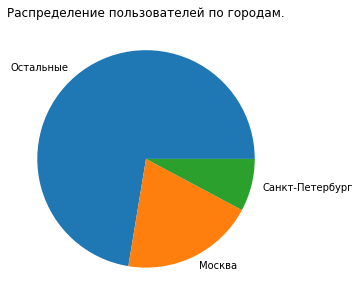

In [14]:
# Посмотрим где живут наши пользователи
data_users['city_grouped'].value_counts().plot(kind='pie', figsize=(7,5))
plt.ylabel('')
plt.title('Распределение пользователей по городам.')
plt.show()

Москва и Санкт-Петербург больше четверти от всех клиентов? Ну это больше чем пропрорционально к населению, но почему-то этот результат не удивляет.

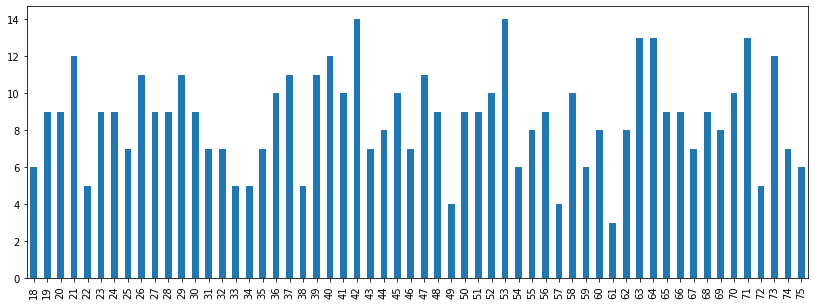

In [15]:
# Посмотрим на возраст
data_users['age'].value_counts().sort_index().plot(kind='bar', figsize=(14,5))
plt.show()

Пользователи распределены по возрасту более-менее равномерно.

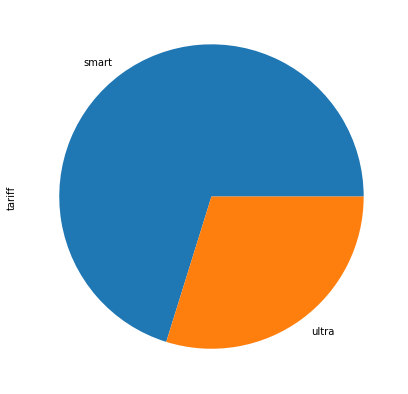

In [16]:
# Каким тарифом пользуются
data_users['tariff'].value_counts().plot(kind='pie', figsize=(7,7))
plt.show()

Соотношение Ultra/Smart получается 30% на 70% соответственно. Вполне хороше соотношение с учетом того что тариф Ultra почти в 4 раза выше.

#### Посмотрим количество сделанных звонков и израсходованных минут разговора по месяцам.

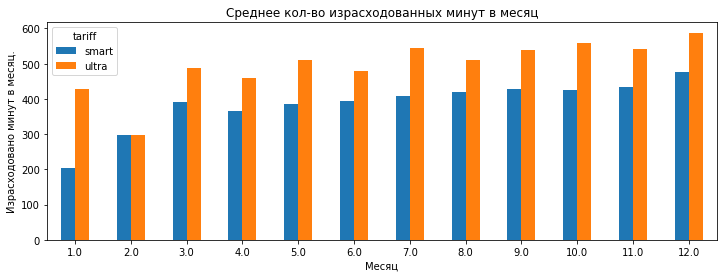

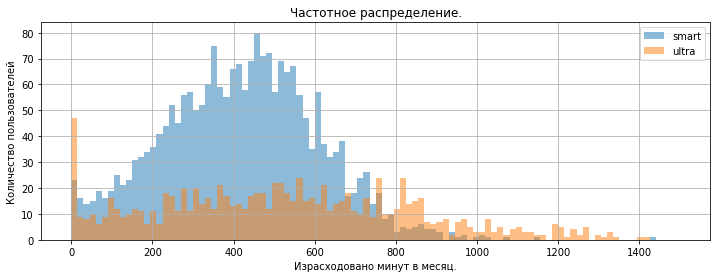

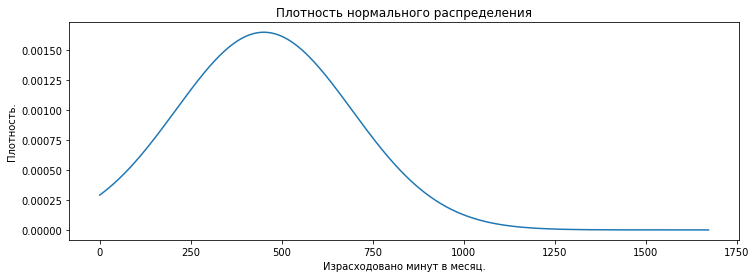

Использовано минут: tariff
smart    417
ultra    526
Name: min_per_month, dtype: int64
Среднее по всем - 450


In [17]:
# Сделаем сводную таблицу со средним количеством минут в месяц.
minutes_mean = full_data.pivot_table(index='month', columns='tariff', 
                                     values='min_per_month', aggfunc='mean').astype('int')
minutes_mean.plot(kind='bar', figsize=(12,4), title='Среднее кол-во израсходованных минут в месяц',
                 rot=0)
plt.xlabel('Месяц')
plt.ylabel('Израсходовано минут в месяц.')
plt.show()

# Посмотри гисторграмму с разбивкой на тарифы
full_data[full_data['tariff'] == 'smart']['min_per_month'].hist(
    bins=100, range=(0, 1500), label='smart', figsize=(12,4), alpha=0.5)
full_data[full_data['tariff'] == 'ultra']['min_per_month'].hist(
    bins=100, range=(0, 1500), label='ultra', figsize=(12,4), alpha=0.5)

plt.xlabel('Израсходовано минут в месяц.')
plt.ylabel('Количество пользователей')
plt.title('Частотное распределение.')
plt.legend()
plt.show()

x = full_data['min_per_month'].sort_values()
# Посчитаем мат. ожидание
mu = x.mean()
# Считаем Дисперсию
variance = np.var(x)
# Вычисление стандартного отклонения. Берем корень из дисперсии.
sigma = variance ** (1/2)
y = st.norm.pdf(x, mu, sigma)
# Посмотрим на график плотности нормального распределения с вычисленными параметрами
plt.plot(x, y)
plt.gcf().set_size_inches(12, 4)
plt.title('Плотность нормального распределения')
plt.xlabel('Израсходовано минут в месяц.')
plt.ylabel('Плотность.')
plt.show()

print("Использовано минут:", full_data.groupby('tariff')['min_per_month'].mean().astype('int'))
print("Среднее по всем -", full_data['min_per_month'].mean().astype('int'))

#### Вывод
В среднем пользователь тарифа smart использует 421 минуту из 500 включенных. А на тарифе ultra используется 556 минут из 3000 включенных. А если посмотерть среднюю по всем вместе, то получится 459 минут.

Из этого можно сделать вывод, что среднему человеку достаточно для разговоров примерно 8 часов в месяц, или 15 минут в день. И даже если в тариф включено сильно больше, это не мотивирует нас общаться больше.

Еще интересный факт в том, у тарифа Ultra некоторые клиенты не пользуются голосовой связью, возможно эти пользователи покупали сим. карту для использования интернета. Возможно даже использовали сим карту в модеме, тогда вполне логично, что у нас небыло звонков.

#### Количество отправленных сообщений по месяцам.

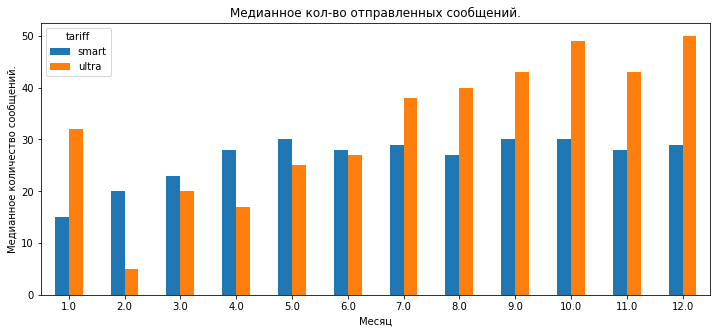

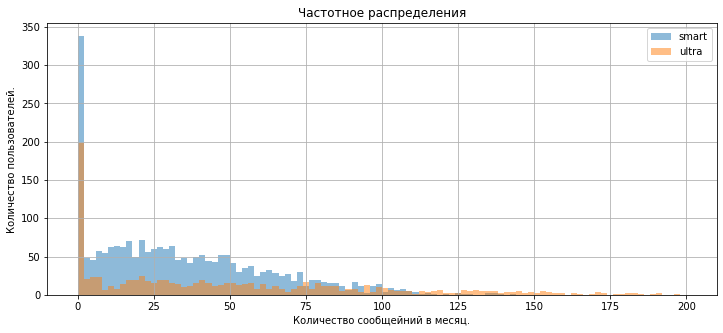

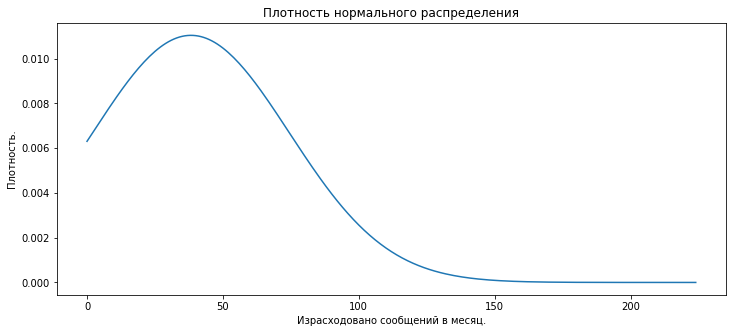

Отправлено sms: tariff
smart    28
ultra    38
Name: sms_per_month, dtype: int64
Среднее по всем - 30


In [18]:
# Посчитаем сколько в среднем отправляется сообщений по месяцам в разрезе тарифов.
messages_mean = full_data.pivot_table(index='month', columns='tariff', 
                                     values='sms_per_month', aggfunc='median').astype('int')

# Посмотрим динамику на месячном графике
messages_mean.plot(kind='bar', figsize=(12,5), title='Медианное кол-во отправленных сообщений.',
                 rot=0)
plt.xlabel('Месяц')
plt.ylabel('Медианное количество сообщений.')
plt.show()

# Гистограмма распределения
full_data[full_data['tariff'] == 'smart']['sms_per_month'].hist(
    bins=100, range=(0, 200), label='smart', alpha=0.5, figsize=(12,5))
full_data[full_data['tariff'] == 'ultra']['sms_per_month'].hist(
    bins=100, range=(0, 200), label='ultra', alpha=0.5, figsize=(12,5))

plt.title('Частотное распределения')
plt.xlabel('Количество сообщейний в месяц.')
plt.ylabel('Количество пользователей.')
plt.legend()
plt.show()

x = full_data['sms_per_month'].sort_values()
# Посчитаем мат. ожидание
mu = x.mean()
# Считаем Дисперсию
variance = np.var(x)
# Вычисление стандартного отклонения. Берем корень из дисперсии.
sigma = variance ** (1/2)
y = st.norm.pdf(x, mu, sigma)
# Посмотрим на график плотности нормального распределения с вычисленными параметрами
plt.plot(x, y)
plt.gcf().set_size_inches(12,5)
plt.title('Плотность нормального распределения')
plt.xlabel('Израсходовано сообщений в месяц.')
plt.ylabel('Плотность.')
plt.show()

print("Отправлено sms:", full_data.groupby('tariff')['sms_per_month'].median().astype('int'))
print("Среднее по всем -", full_data['sms_per_month'].median().astype('int'))

#### Вывод
С сообщенияму лучше использовать медиану, т.к. часть людей почти полностью общаются в мессенджерах, а для части sms - это еще полноценный канал коммуникаций.

Пользователи тарифа smart отправляют медианно 34 сообщения из включенных 50. На тарифе ultra отправляют медианно 53 сообщения из включенных 1000. Медиана по всем вместе взятым 38 sms в месяц. 

Что тут скажешь, 1-2 sms в день это максимум, все остальное общение остается месенджерам.

#### Объем израсходованного интернет-трафика по месяцам.

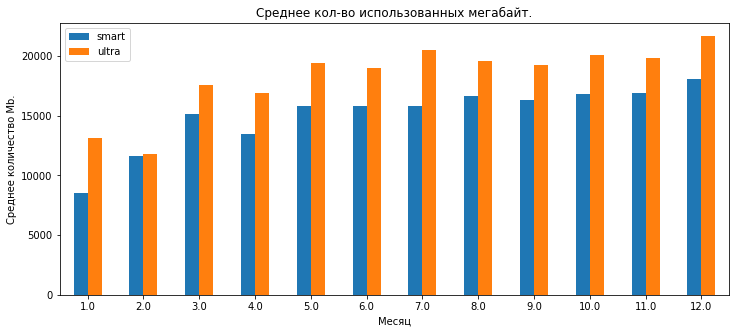

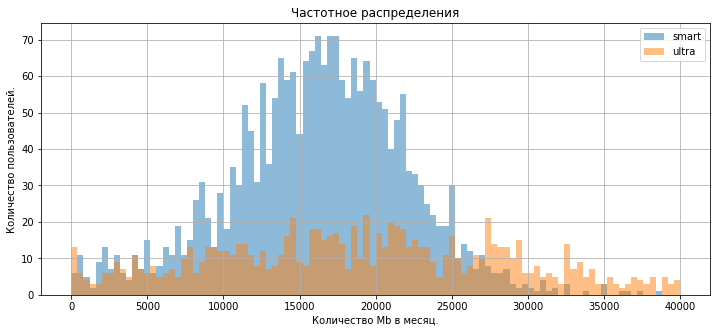

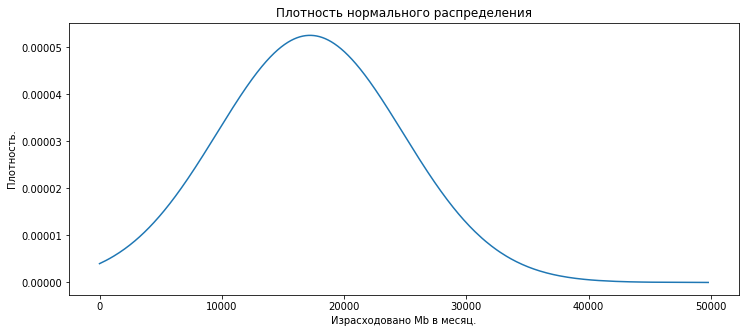

Использовано Mb: tariff
smart    16529
ultra    19320
Name: mb_per_month, dtype: int64
Среднее по всем - 17216


In [19]:
# Сделаем сводную таблицу со средним расходом трафика в месяц
mb_mean = full_data.pivot_table(index='month', columns='tariff', 
                                     values='mb_per_month', aggfunc='mean').astype('int')
mb_mean.plot(kind='bar', figsize=(12,5), title='Среднее кол-во использованных мегабайт.',
                 rot=0)
plt.xlabel('Месяц')
plt.ylabel('Среднее количество Mb.')
plt.legend()
plt.show()

full_data[full_data['tariff'] == 'smart']['mb_per_month'].hist(
    bins=100, range=(0, 40000), label='smart', alpha=0.5, figsize=(12,5))
full_data[full_data['tariff'] == 'ultra']['mb_per_month'].hist(
    bins=100, range=(0, 40000), label='ultra', alpha=0.5, figsize=(12,5))

plt.title('Частотное распределения')
plt.xlabel('Количество Mb в месяц.')
plt.ylabel('Количество пользователей.')
plt.legend()
plt.show()

x = full_data['mb_per_month'].sort_values()
# Посчитаем мат. ожидание
mu = x.mean()
# Считаем Дисперсию
variance = np.var(x)
# Вычисление стандартного отклонения. Берем корень из дисперсии.
sigma = variance ** (1/2)
y = st.norm.pdf(x, mu, sigma)
# Посмотрим на график плотности нормального распределения с вычисленными параметрами
plt.plot(x, y)
plt.gcf().set_size_inches(12,5)
plt.title('Плотность нормального распределения')
plt.xlabel('Израсходовано Mb в месяц.')
plt.ylabel('Плотность.')
plt.show()

print("Использовано Mb:", full_data.groupby('tariff')['mb_per_month'].median().astype('int'))
print("Среднее по всем -", full_data['mb_per_month'].mean().astype('int'))

#### Вывод
Средний расход трафика на тарифе smart 16.5 Гб из 15 Гб включенных. На тарифе ultra 19.5 Гб из 30 Гб включенных. 

Вот что нужно людям! Уже средние значения на тарифе smart превышают включенные лимиты.

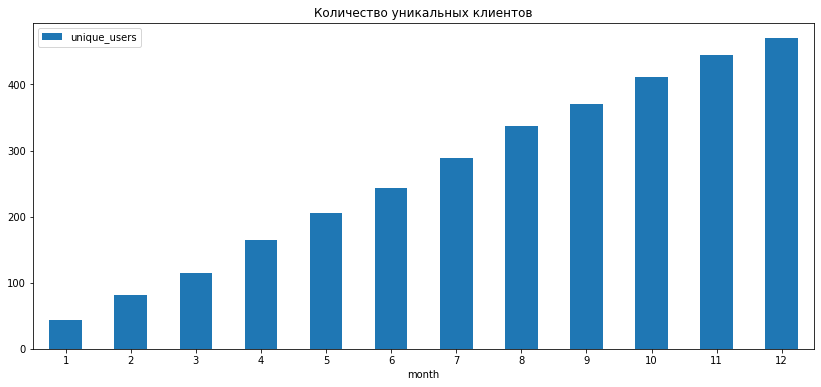

In [20]:
# Посмотрим количество уникальных клиентов по каждому месяцу.
calls_pvt = data_calls.pivot_table(index = 'month',
                       values='user_id', aggfunc=lambda x: len(x.unique()))
calls_pvt.columns = ['unique_users']
calls_pvt.plot(kind='bar', figsize=(14,6), rot=0, title='Количество уникальных клиентов')
plt.show()

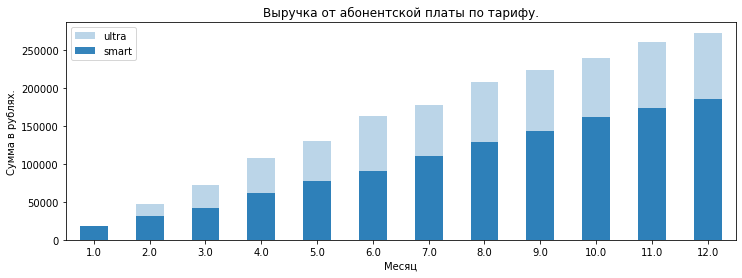

In [21]:
# Посмотрим сколько общей выручки получаем ежемесячно по фиксированному тарифу
full_data[full_data['tariff'] == 'ultra'].groupby('month')['rub_monthly_fee'].sum().plot(
    kind='bar', alpha=0.3, label='ultra', figsize=(12,4))
full_data[full_data['tariff'] == 'smart'].groupby('month')['rub_monthly_fee'].sum().plot(
    kind='bar', alpha=0.9, label='smart', rot=0)
plt.title('Выручка от абонентской платы по тарифу.')
plt.ylabel('Сумма в рублях.')
plt.xlabel('Месяц')
plt.legend()
plt.show()

### Вывод
По фиксированным ежемесячным платежам тариф ultra приносит в сумме больше денег. Посмотрим что будет когда мы добавим все допольнительные платежи за перерасходы лимитов.

### Посчитаем сколько в среднем мы получаем выручки по каждому пользователю в зависимости от тарифа и общую выручку в месяц в зависимости от тарифа.

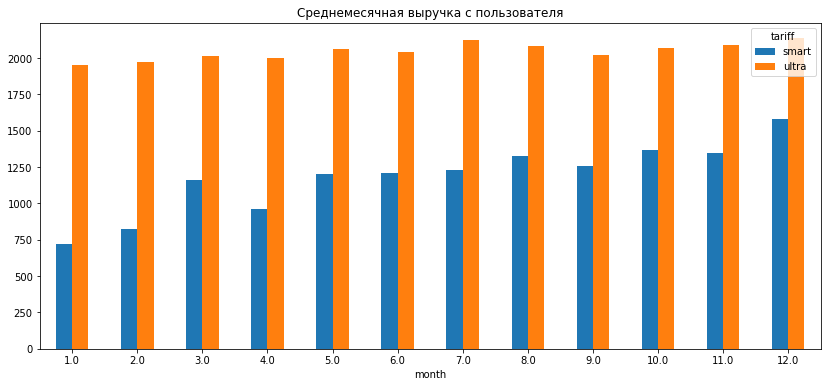

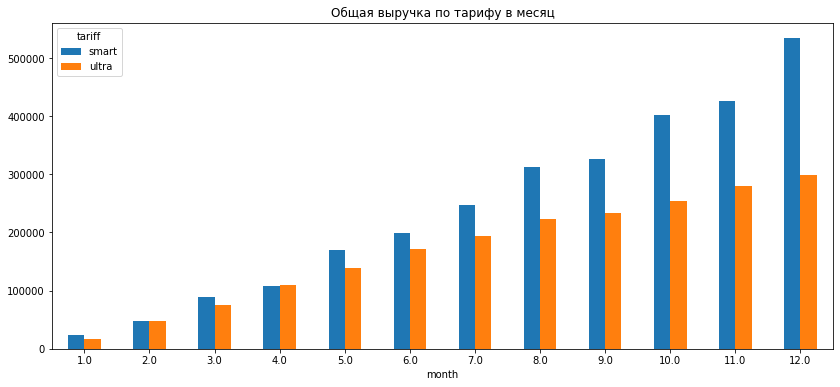

Среднемесячная выручка по тарифу smart - 1182 руб.
Медианная выручка по тарифу smart - 1218 руб.
Среднемесячная выручка по тарифу ultra - 2047 руб.
Медианная выручка по тарифу ultra - 2051 руб.


In [22]:
# Посчитаем среднемесячную выручку по каждому тарифу
mean_revenue = full_data.pivot_table(index='month', columns='tariff', 
                                     values='total_revenue', aggfunc='mean').astype('int')
# Посмотрим динамику на графике
mean_revenue.plot(kind='bar', figsize=(14,6), rot=0, title='Среднемесячная выручка с пользователя')
plt.show()

# Посчитает общую выручку за месяц по каждому тарифу
total_revenue = full_data.pivot_table(index='month', columns='tariff', 
                                      values='total_revenue', aggfunc='sum').astype('int')

# Посмотрим динамику на графике
total_revenue.plot(kind='bar', figsize=(14,6), rot=0, title='Общая выручка по тарифу в месяц')
plt.show()

print('Среднемесячная выручка по тарифу smart - {} руб.'.format(int(mean_revenue['smart'].mean())))
print('Медианная выручка по тарифу smart - {} руб.'.format(int(mean_revenue['smart'].median())))
print('Среднемесячная выручка по тарифу ultra - {} руб.'.format(int(mean_revenue['ultra'].mean())))
print('Медианная выручка по тарифу ultra - {} руб.'.format(int(mean_revenue['ultra'].median())))

#### Вывод
Средняя ежемесячная выручка с одного пользователя, у тарифа ultra почти в два раза больше чем у smart. При этом общая выручка по всем клиентам выше у тарифа smart. Что объясняется тем, что клиентов на тарифе smart больше.

Интересно, что средняя выручка по тарифу smart растет на протяжении года. Интересно посмотреть за счет чего растет эта выручка.

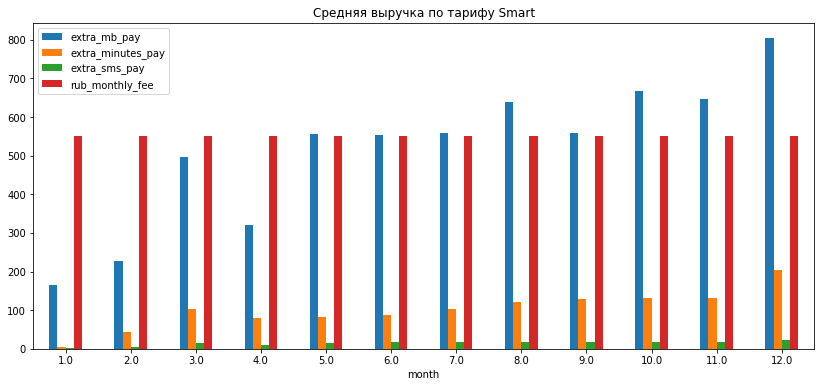

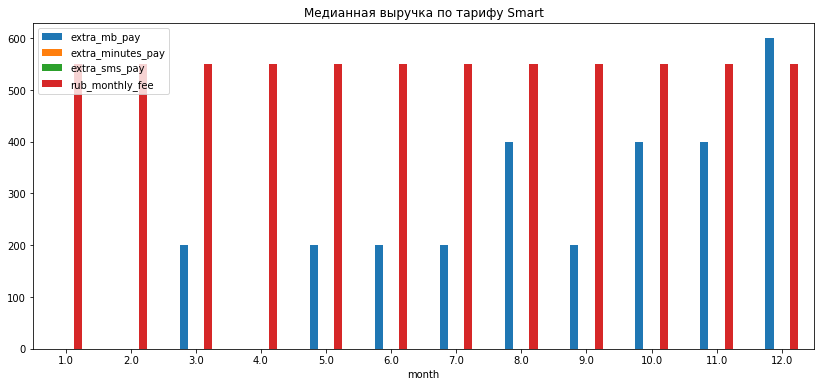

In [23]:
# Посчитаем стреднюю выручку по тарифу smart по компонентам.
smart_revenue = full_data[full_data['tariff'] == 'smart'].pivot_table(
    index='month', values=['rub_monthly_fee','extra_minutes_pay',
                                 'extra_mb_pay','extra_sms_pay'],
    aggfunc='mean').astype('int')
# Посмотрим динамику на графике
smart_revenue.plot(kind='bar', figsize=(14,6), rot=0, title='Средняя выручка по тарифу Smart')
plt.show()

# Посчитаем медианную выручку по тарифу smart по компонентам.
smart_revenue = full_data[full_data['tariff'] == 'smart'].pivot_table(
    index='month', values=['rub_monthly_fee','extra_minutes_pay',
                                 'extra_mb_pay','extra_sms_pay'],
    aggfunc='median').astype('int')
# Посмотрим динамику на графике
smart_revenue.plot(kind='bar', figsize=(14,6), rot=0, title='Медианная выручка по тарифу Smart')
plt.show()

#### Вывод
В нашем случае лучше смотреть на медиану, что бы отбросить пользователей с очень большим перерасходом трафика.

На графике видно что популярность мобильного интернета растет, а вместе с ней растет и выручка оператора за перерасход трафика. И часть пользователей платит за дополнительный трафик больше чем ежемесячный платеж по тарифу.

Ну и можно понять что многим пользователям хватает включенных минут и смс.

### Шаг 4. Проверка гипотез

#### 1. Средняя выручка
Гипотеза Н0 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.

Гипотеза Н1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [24]:
smart_data = full_data[full_data['tariff'] == 'smart']['total_revenue']
ultra_data = full_data[full_data['tariff'] == 'ultra']['total_revenue']
alpha = 0.05
ttest = st.ttest_ind(smart_data, ultra_data).pvalue
if ttest < alpha:
    print('Верна гипотеза Н1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.')
else:
    print('Верна гипотеза Н0 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.')

print('p_value = {:.2f}'.format(ttest))

Верна гипотеза Н1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
p_value = 0.00


#### 2 . Отличие выручки в Москве с другими городами
Гипотеза Н0 - Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Гипотеза Н1 - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [25]:
moscow_data = full_data[full_data['city_grouped'] == 'Москва']['total_revenue']
other_data = full_data[full_data['city_grouped'] != 'Москва']['total_revenue']
alpha = 0.05
ttest = st.ttest_ind(moscow_data, other_data).pvalue
if ttest < alpha:
    print('Верна гипотеза Н1')
    print('Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.')
else:
    print('Верна гипотеза Н0')
    print('Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.')

print('p_value = {:.2f}'.format(ttest))

Верна гипотеза Н0
Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
p_value = 0.53


#### 3. Возможная причина ухода пользователей - дополнительные платежи сверх тарифа

Гипотеза Н0 - Средняя плата за перерасход лимитов тех кто ушел, не отличается от тех, кто остался.

Гипотеза Н1 - Средняя плата за перерасход лимитов тех кто ушел, больше чем у тех кто остался.

In [26]:
churn_data = full_data[full_data['is_churn'] == True]['extra_pay_total']
other_data = full_data[full_data['is_churn'] == False]['extra_pay_total']
alpha = 0.05
ttest = st.ttest_ind(churn_data, other_data).pvalue / 2
if ttest < alpha and churn_data.mean() > other_data.mean():
    print('Верна гипотеза Н1')
    print('Средняя плата за перерасход лимитов тех кто ушел, больше чем у тех кто остался.')
else:
    print('Верна гипотеза Н0')
    print('Средняя плата за перерасход лимитов тех кто ушел, не отличается от тех, кто остался.')
    
print('p_value = {:.2f}'.format(ttest))

Верна гипотеза Н0
Средняя плата за перерасход лимитов тех кто ушел, не отличается от тех, кто остался.
p_value = 0.00


### Шаг 5. Общий вывод

В ходе исследования мы нашли следующие интересные моменты:
 - В среднем человек делает исходящих вызовов на 15 минут в день, в не зависимости от тарифов и лимитов. И среднее время одного звонка - 8 минут.
 - 1-2 sms это все что нужно современному человеку в месяц. Преположим что статистика отправленных сообщений в месанджерах сильно выше, но из наших данных мы можем это лишь предполагать.
 - Что касается трафика интернета, то потребности клиентов растут и люди готовы платить за то что бы получить дополнительный трафик.

Мы проверили ряд гипотез и выяснили:
 - Средняя выручка у пользователей ультра и смарт отличается
 - Средняя выручка у пользователей из Москвы не отличается от остальных населенных пунктов.
 - Люди который перестали пользоваться тарифом, в среднем делали дополнительных платежей не больше чем остальные.
 
Один из выводов исследования в том, что средняя выручка по тарифу Ultra составляет **2028** рублей, а это на **40** процентов больше чем у тарифа Smart, со средней выручкой в **1185** рублей. Как следствие логично скорректировать рекламный бюджет в сторону продвижения тарифа **Ultra**, который приносит больше денег.

С другой стороны, мы наблюдаем рост выручки тарифа Smart на протяжении года. А это значит что при действующей рекламной политике мы получаем большинство клиентов на тариф Smart, и при действующих настройках самих тарифов, мы получаем рост выручки от месяца к месяцу. Это дает основания предполагать, что если оставить все как есть, то динамика выручки будет и дальше положительной.

В итоге одним из логических решений по итогам анализа, будет все же корректировка рекламного бюджета в пользу тарифа Ultra т.к. в данный момент он приносит больше выручки с одного пользователя. При этом нужно продолжать наблюдения за тарифом Smart и если рост выручки продолжится и дальше, делать дополнительный анализ и дополнительные корректировки.

-----